# Patch preprocessing

This notebook contains the code to preprocess every patch file. The steps are the following:
1. Unzip all the tiff files for every patch (one per band).
2. Stack all bands together in order to create a unique image.
3. Write the stacked tiff images in the folder patches_clean.

In [1]:
import os
import zipfile
from glob import glob
import rasterio as rio
import numpy as np
import re
import tifffile
from skimage.io import imread
import matplotlib.pyplot as plt
import earthpy.plot as ep
import earthpy.spatial as es

## Unzip files

In [71]:
# Get names of all the zips
zips_dirs = os.listdir("../data/patches_raw/leak/")

# Remove .zip extension from the name
patch_dir_names = [name[:15] for name in zips_dirs]

parent_dir = "../data/patches_raw/leak/"

for dir, patch_dir in zip(zips_dirs, patch_dir_names):
    path_zip = os.path.join(parent_dir, dir)
    if zipfile.is_zipfile(path_zip):
        with zipfile.ZipFile(path_zip) as item:
            item.extractall(os.path.join(parent_dir, patch_dir))

## Stack bands

In [72]:
patches_bands = glob("../data/patches_raw/leak/S2_2022-12-01_0/*B*.tif")

def my_digit_sort(my_list):
   return list(map(int, re.findall(r'(?<=.B)\d+(?=A?.tif)', my_list)))[0]

patches_bands.sort(key = my_digit_sort)
patches_bands.append(glob("../data/patches_raw/leak/S2_2022-12-01_0/*WVP*.tif")[0])
patches_bands.append(glob("../data/patches_raw/leak/S2_2022-12-01_0/*LST*.tif")[0])
patches_bands

['../data/patches_raw/leak/S2_2022-12-01_0\\20221125T171639_20221125T172303_T13QGE.B1.tif',
 '../data/patches_raw/leak/S2_2022-12-01_0\\20221125T171639_20221125T172303_T13QGE.B2.tif',
 '../data/patches_raw/leak/S2_2022-12-01_0\\20221125T171639_20221125T172303_T13QGE.B3.tif',
 '../data/patches_raw/leak/S2_2022-12-01_0\\20221125T171639_20221125T172303_T13QGE.B4.tif',
 '../data/patches_raw/leak/S2_2022-12-01_0\\20221125T171639_20221125T172303_T13QGE.B5.tif',
 '../data/patches_raw/leak/S2_2022-12-01_0\\20221125T171639_20221125T172303_T13QGE.B6.tif',
 '../data/patches_raw/leak/S2_2022-12-01_0\\20221125T171639_20221125T172303_T13QGE.B7.tif',
 '../data/patches_raw/leak/S2_2022-12-01_0\\20221125T171639_20221125T172303_T13QGE.B8.tif',
 '../data/patches_raw/leak/S2_2022-12-01_0\\20221125T171639_20221125T172303_T13QGE.B8A.tif',
 '../data/patches_raw/leak/S2_2022-12-01_0\\20221125T171639_20221125T172303_T13QGE.B9.tif',
 '../data/patches_raw/leak/S2_2022-12-01_0\\20221125T171639_20221125T172303_T13

In [73]:
stacked_patches = []
for patch in patches_bands:
    with rio.open(patch, "r") as f:
        stacked_patches.append(f.read(1))
        print(f.profile)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 21, 'height': 21, 'count': 1, 'crs': CRS.from_epsg(32613), 'transform': Affine(10.0, 0.0, 781460.0,
       0.0, -10.0, 2419600.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 21, 'height': 21, 'count': 1, 'crs': CRS.from_epsg(32613), 'transform': Affine(10.0, 0.0, 781460.0,
       0.0, -10.0, 2419600.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 21, 'height': 21, 'count': 1, 'crs': CRS.from_epsg(32613), 'transform': Affine(10.0, 0.0, 781460.0,
       0.0, -10.0, 2419600.0), 'blockxsize': 256, 'blockysize': 256, 'tiled': True, 'compress': 'deflate', 'interleave': 'band'}
{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 21, 'height': 21, 'count': 1, 'crs': CRS.from_epsg(32613), 't

In [74]:
# stack bands into an nd array
stacked_patch = np.stack(stacked_patches)
stacked_patch.shape

(14, 21, 21)

In [6]:
np.transpose(stacked_patch).shape

(21, 21, 14)

In [ ]:
# Save stacked tif image
image_name = re.search(r"(?<=\\)(.*?)(?=.B)", patches_bands[0]).group()
tifffile.imwrite("../data/patches_clean/leak/" + image_name + ".tif", stacked_patch)
stacked_image = tifffile.imread("../data/patches_clean/leak/" + image_name + ".tif")
stacked_image.shape

### Generalize stacking for all images (leak)

In [75]:
# Function to order tif files by their band name
def my_digit_sort(my_list):
   return list(map(int, re.findall(r'(?<=.B)\d+(?=A?.tif)', my_list)))[0]

In [76]:
# Get list of all patch directories
image_directories = os.listdir("../data/patches_raw/leak/")

# Remove zip files from list
pattern = re.compile("^S.*\d$")
image_directories_nozips = list(filter(pattern.match, image_directories))

# Get band path for each patch
id = 0
for image_dir in image_directories_nozips:
    patches_bands = glob("../data/patches_raw/leak/" + image_dir + "/*B*.tif")
    patches_bands.sort(key = my_digit_sort)
    patches_bands.append(glob("../data/patches_raw/leak/" + image_dir + "/*WVP*.tif")[0])
    patches_bands.append(glob("../data/patches_raw/leak/" + image_dir + "/*LST*.tif")[0])

    stacked_patches = []
    for patch in patches_bands:
        with rio.open(patch, "r") as f:
            stacked_patches.append(f.read(1))
    
    stacked_patch = np.transpose(np.stack(stacked_patches))

    image_name = re.search(r"(?<=\\)(.*?)(?=.B)", patches_bands[0]).group()
    # Add id
    image_name = image_name + "_leak" + str(id)

    # Create stacked image save directory in patches_clean
#    save_path = "../data/patches_clean/leak/" + image_dir

#    if os.path.exists(save_path) == False:
#        os.mkdir(save_path)

    # Write stacked patch
    tifffile.imwrite("../data/patches_clean/leak/" + image_name + ".tif", stacked_patch)
    id += 1 

In [78]:
# Check if stacked images were saved correctly
stacked_image_leak = imread("../data/patches_clean/leak/20221125T171639_20221125T172303_T13QGE_leak0.tif")

### Generalize for non leak images

In [79]:
## Unzip

# Get names of all the zips
zips_dirs = os.listdir("../data/patches_raw/non_leak")

# Remove .zip extension from the name
patch_dir_names = [name[:15] for name in zips_dirs]

parent_dir = "../data/patches_raw/non_leak/"

for dir, patch_dir in zip(zips_dirs, patch_dir_names):
    path_zip = os.path.join(parent_dir, dir)
    if zipfile.is_zipfile(path_zip):
        with zipfile.ZipFile(path_zip) as item:
            item.extractall(os.path.join(parent_dir, patch_dir))

In [80]:
# Get list of all patch directories
image_directories = os.listdir("../data/patches_raw/non_leak")

# Remove zip files from list
pattern = re.compile("^S.*\d$")
image_directories_nozips = list(filter(pattern.match, image_directories))

# Get band path for each patch
id = 0
for image_dir in image_directories_nozips:
    patches_bands = glob("../data/patches_raw/non_leak/" + image_dir + "/*B*.tif")
    patches_bands.sort(key = my_digit_sort)
    patches_bands.append(glob("../data/patches_raw/non_leak/" + image_dir + "/*WVP*.tif")[0])
    patches_bands.append(glob("../data/patches_raw/non_leak/" + image_dir + "/*LST*.tif")[0])

    stacked_patches = []
    for patch in patches_bands:
        with rio.open(patch, "r") as f:
            stacked_patches.append(f.read(1))
    
    stacked_patch = np.transpose(np.stack(stacked_patches))

    image_name = re.search(r"(?<=\\)(.*?)(?=.B)", patches_bands[0]).group()
    # Add id
    image_name = image_name + "_nonleak" + str(id)

    # Create stacked image save directory in patches_clean
    #save_path = "../data/patches_clean/non_leak/" + image_dir
    #if os.path.exists(save_path) == False:
    #    os.mkdir(save_path)

    # Write stacked patch
    tifffile.imwrite("../data/patches_clean/non_leak/" + image_name + ".tif", stacked_patch)
    id += 1

In [81]:
# Check if stacked images were saved correctly
# stacked_image_nonleak = imread("../data/patches_clean/non_leak/20221210T171721_20221210T172008_T13QGE_nonleak0.tif")
stacked_image_nonleak = imread("../data/patches_clean/non_leak/20221215T171719_20221215T172149_T13QGE_nonleak0.tif")

In [82]:
# Print values of pixels
stacked_patch.min(), stacked_patch.max()

(461.0, 46703.13973407858)

In [83]:
# Normalize patch in order to plot
stacked_patch_norm = stacked_patch / 1000
stacked_patch_norm.min(), stacked_patch_norm.max()

(0.461, 46.703139734078576)

In [84]:
# Extract band name in order to use it as plot title
titles = [re.search(r"(?<=T13QGE.)(.*)(?=.tif)", band).group() for band in patches_bands]
titles

['B1',
 'B2',
 'B3',
 'B4',
 'B5',
 'B6',
 'B7',
 'B8',
 'B8A',
 'B9',
 'B11',
 'B12',
 'WVP',
 'LST_10m']

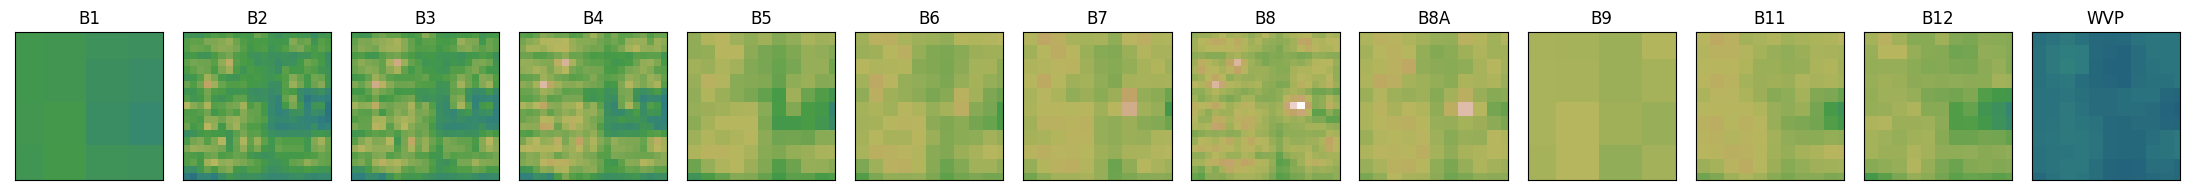

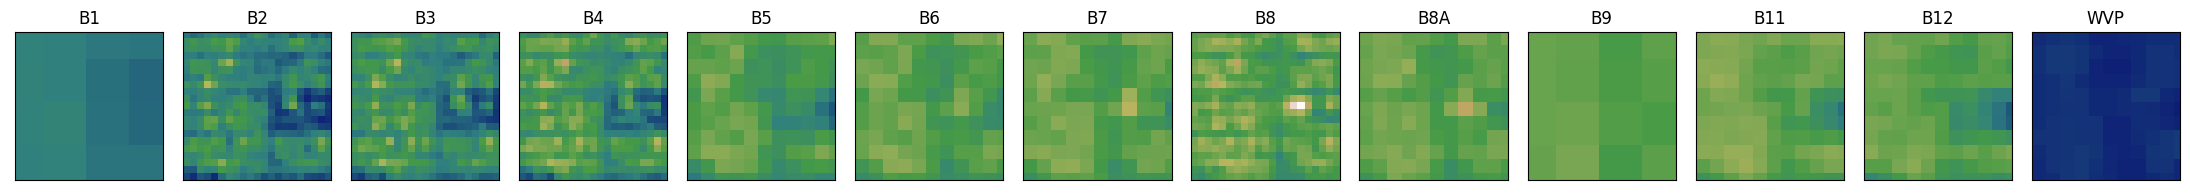

In [85]:

ep.plot_bands(
    arr = np.transpose(stacked_image_leak[:, :, :13]), cmap = "gist_earth",
    figsize = (22, 10), cols = 13,
    cbar = False, title = titles[:13],
    vmin = 0, vmax = stacked_image_leak[:, :, :12].max()
)

ep.plot_bands(
    arr = np.transpose(stacked_image_nonleak[:, :, :13]), cmap = "gist_earth",
    figsize = (22, 10), cols = 13,
    cbar = False, title = titles[:13],
    vmin = 0, vmax = stacked_image_nonleak[:, :, :12].max()
)

plt.show()


In [86]:
# Plot bands for 5 images leak vs nonleak

# Get path of images
leak_images_paths = glob("../data/patches_clean/leak/*leak*")
nonleak_images_paths = glob("../data/patches_clean/non_leak/*nonleak*")


In [87]:
# Function to order paths by their id
def my_path_sort(my_list):
   return list(map(int, re.findall(r'(?<=leak)\d+(?=.tif)', my_list)))[0]

In [88]:
leak_images_paths.sort(key = my_path_sort)
nonleak_images_paths.sort(key = my_path_sort)

In [89]:
for i in range(0, len(leak_images_paths)):
    tif_leak = imread(leak_images_paths[i])
    tif_nonleak = imread(nonleak_images_paths[i])
    print(tif_leak[:,:,:13].max(), tif_nonleak[:, :, :13].max())
    for j, band in zip(range(0, len(titles)), titles):
        print(band, tif_leak[:, :, j].max(), tif_nonleak[:, :, j].max())

4460.0 5016.0
B1 2006.0 1561.0
B2 3500.0 3528.0
B3 3732.0 3588.0
B4 3948.0 3980.0
B5 3218.0 3017.0
B6 3383.0 3033.0
B7 3746.0 3587.0
B8 4460.0 5016.0
B8A 3977.0 3848.0
B9 3101.0 2753.0
B11 3372.0 3188.0
B12 3226.0 2962.0
WVP 1277.0 651.0
LST_10m 45645.87354864435 44147.91262181578
3672.0 4068.0
B1 2144.0 2078.0
B2 3062.0 3164.0
B3 3340.0 3372.0
B4 3632.0 3820.0
B5 3440.0 3609.0
B6 3361.0 3647.0
B7 3569.0 3629.0
B8 3672.0 4068.0
B8A 3483.0 3707.0
B9 3174.0 3307.0
B11 3472.0 3996.0
B12 3210.0 3780.0
WVP 1290.0 623.0
LST_10m 46555.94225928154 46256.10882741349
3823.0 3976.0
B1 2052.0 1659.0
B2 3192.0 3260.0
B3 3416.0 3280.0
B4 3808.0 3696.0
B5 3453.0 3119.0
B6 3424.0 3284.0
B7 3496.0 3178.0
B8 3804.0 3976.0
B8A 3432.0 3324.0
B9 3171.0 3017.0
B11 3823.0 3922.0
B12 3243.0 3216.0
WVP 1314.0 660.0
LST_10m 47177.7607538561 48836.730110821816
5448.0 5208.0
B1 2743.0 2644.0
B2 5448.0 5112.0
B3 5376.0 5208.0
B4 5332.0 5208.0
B5 5133.0 4924.0
B6 4753.0 4586.0
B7 4690.0 4387.0
B8 4880.0 4908.0
B8A 

In [90]:
for i in range(0, len(leak_images_paths)):
    tif_nonleak = imread(nonleak_images_paths[i])
    print(tif_nonleak[:,:,:13].max())
    for j, band in zip(range(0, len(titles)), titles):
        print(band, tif_nonleak[:, :, j].max())

5016.0
B1 1561.0
B2 3528.0
B3 3588.0
B4 3980.0
B5 3017.0
B6 3033.0
B7 3587.0
B8 5016.0
B8A 3848.0
B9 2753.0
B11 3188.0
B12 2962.0
WVP 651.0
LST_10m 44147.91262181578
4068.0
B1 2078.0
B2 3164.0
B3 3372.0
B4 3820.0
B5 3609.0
B6 3647.0
B7 3629.0
B8 4068.0
B8A 3707.0
B9 3307.0
B11 3996.0
B12 3780.0
WVP 623.0
LST_10m 46256.10882741349
3976.0
B1 1659.0
B2 3260.0
B3 3280.0
B4 3696.0
B5 3119.0
B6 3284.0
B7 3178.0
B8 3976.0
B8A 3324.0
B9 3017.0
B11 3922.0
B12 3216.0
WVP 660.0
LST_10m 48836.730110821816
5208.0
B1 2644.0
B2 5112.0
B3 5208.0
B4 5208.0
B5 4924.0
B6 4586.0
B7 4387.0
B8 4908.0
B8A 3960.0
B9 3344.0
B11 4301.0
B12 4457.0
WVP 1107.0
LST_10m 44996.91897423876
3976.0
B1 1611.0
B2 3260.0
B3 3280.0
B4 3696.0
B5 3119.0
B6 3284.0
B7 3180.0
B8 3976.0
B8A 3358.0
B9 3017.0
B11 3922.0
B12 3216.0
WVP 660.0
LST_10m 49949.88250112652
3976.0
B1 1611.0
B2 3260.0
B3 3280.0
B4 3696.0
B5 3119.0
B6 3284.0
B7 3180.0
B8 3976.0
B8A 3358.0
B9 3017.0
B11 3922.0
B12 3216.0
WVP 660.0
LST_10m 49833.696944670475
4

### Functions to plot multiple bands, lst and nmdi

In [91]:
def norm_bands(tif):
    return (tif - tif.min())/(tif.max() - tif.min())

def plot_bands(leak_tif_path, nonleak_tif_path):
    leak_tif = norm_bands(imread(leak_tif_path))
    nonleak_tif = norm_bands(imread(nonleak_tif_path))

    print("leak")
    ep.plot_bands(
        arr = np.transpose(leak_tif[:, :, :13]), cmap = "gist_earth",
        figsize = (22, 10), cols = 13,
        cbar = True, title = titles[:13],
        vmin = 0, vmax = leak_tif[:, :, :13].max()
    )

    print("nonleak")
    ep.plot_bands(
        arr = np.transpose(nonleak_tif[:, :, :13]), cmap = "gist_earth",
        figsize = (22, 10), cols = 13,
        cbar = True, title = titles[:13],
        vmin = 0, vmax = nonleak_tif[:, :, :13].max()
    )

    plt.show()

In [92]:
def plot_lst(leak_tif_path, nonleak_tif_path):
    leak_tif = norm_bands(imread(leak_tif_path))
    nonleak_tif = norm_bands(imread(nonleak_tif_path))
    fig = plt.figure()
    fig.add_subplot(1, 2, 1)
    fig.colorbar(plt.imshow(leak_tif[:,:,13], cmap = "gnuplot"))
    plt.title("leak")
    
    fig.add_subplot(1, 2, 2)
    fig.colorbar(plt.imshow(nonleak_tif[:,:,13], cmap = "gnuplot"))
    
    plt.title("no leak")

### Multiple bands plots

leak


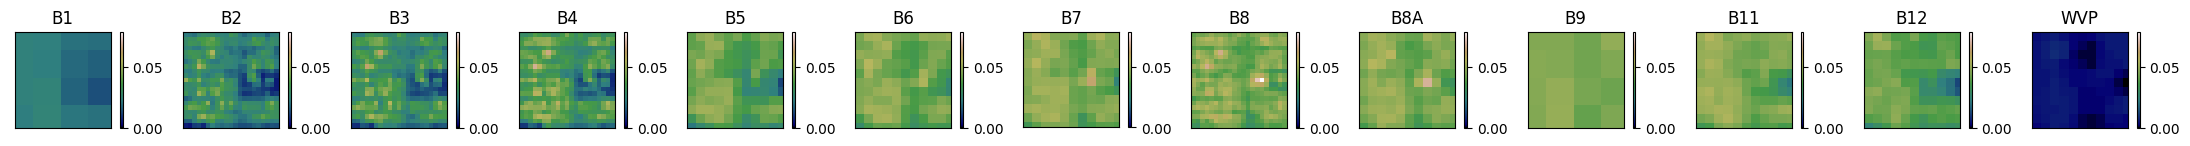

nonleak


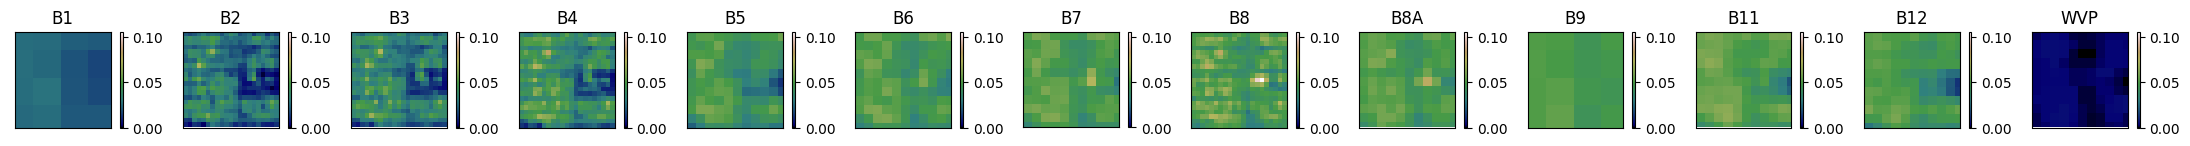

leak


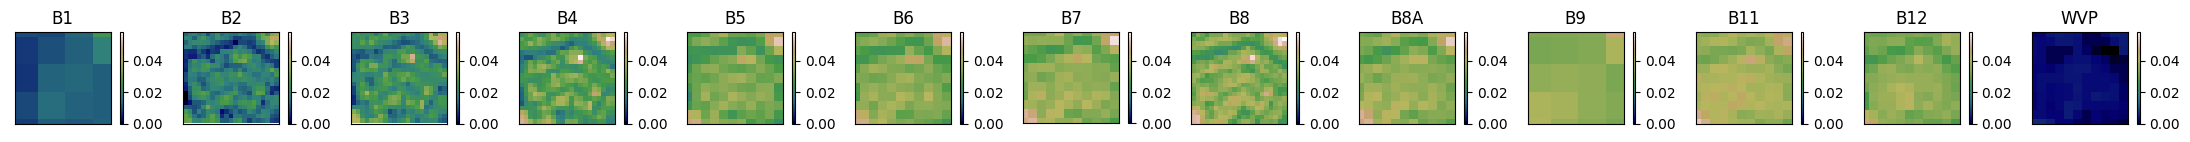

nonleak


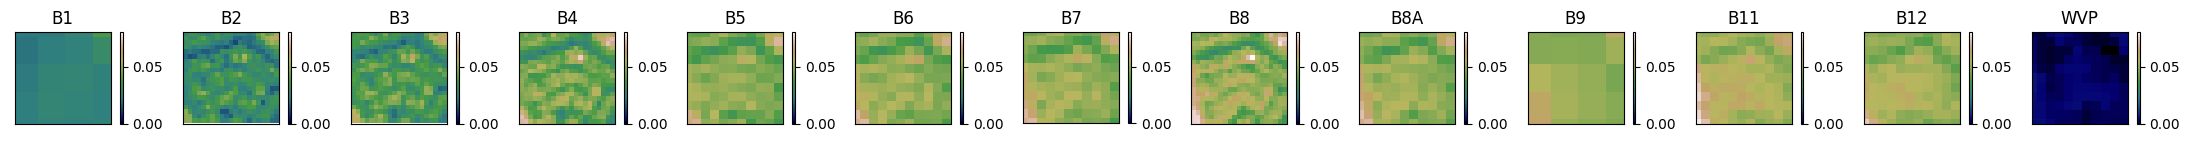

leak


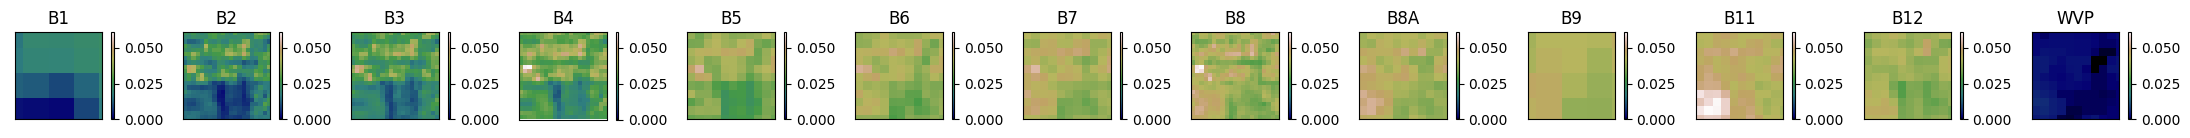

nonleak


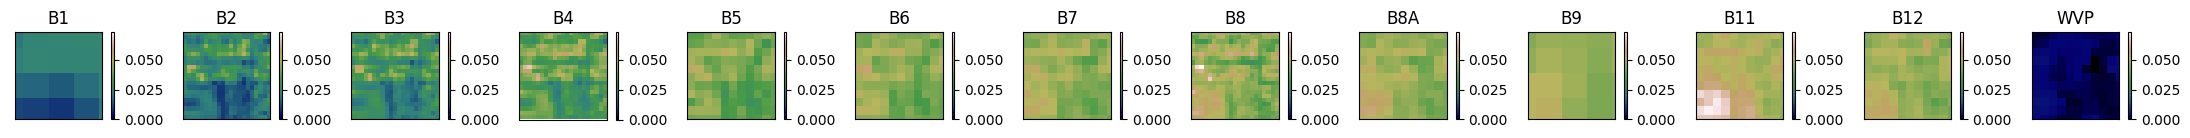

leak


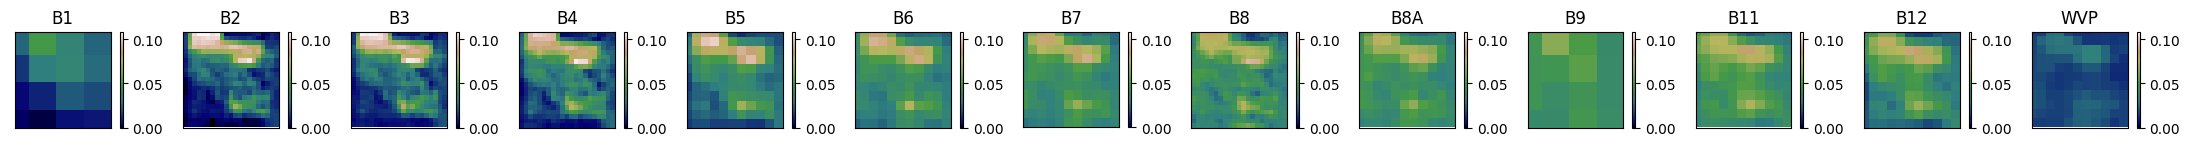

nonleak


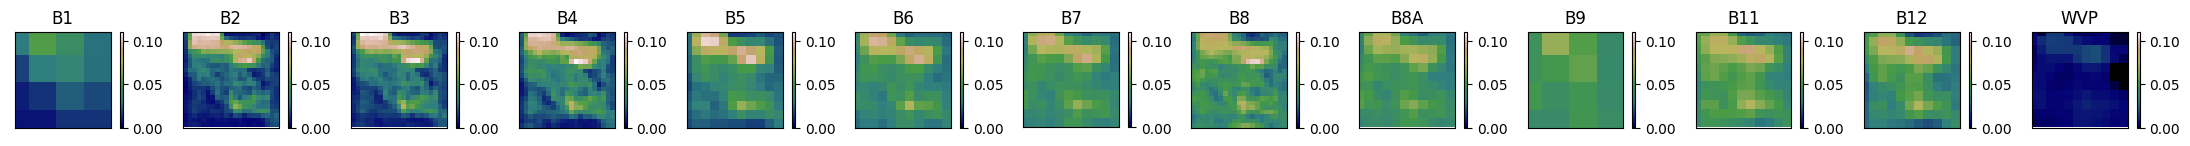

leak


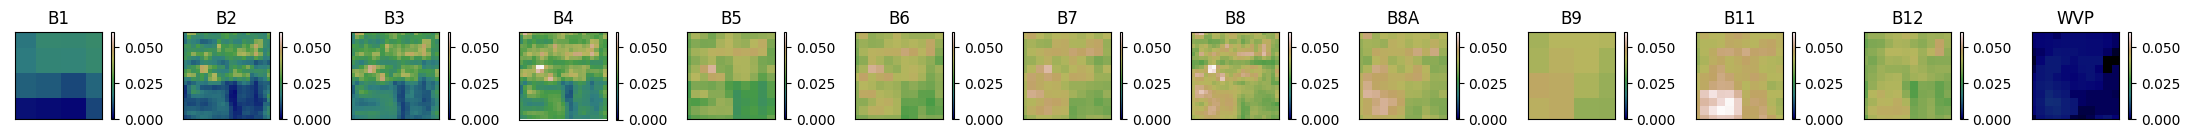

nonleak


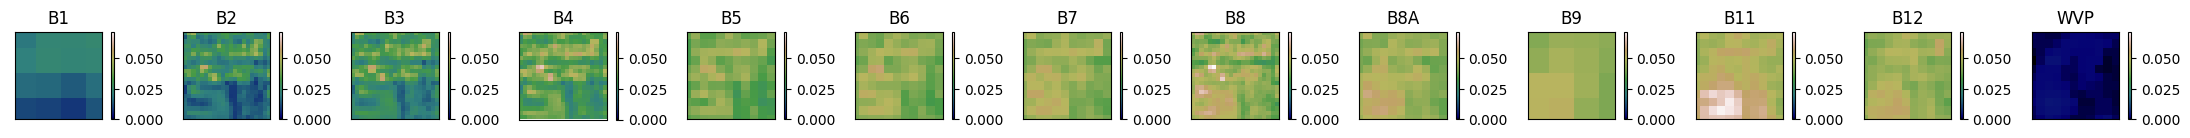

leak


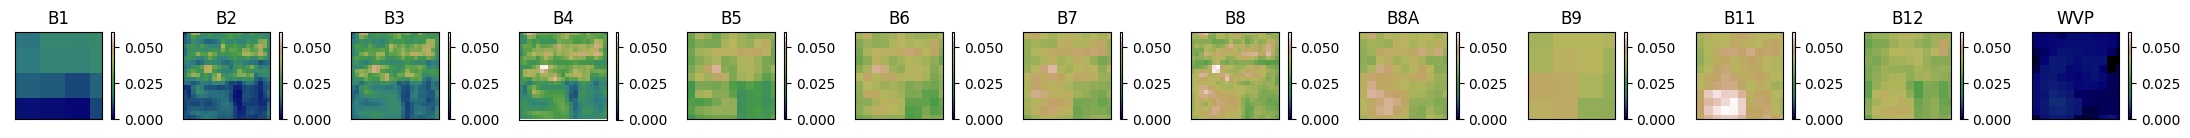

nonleak


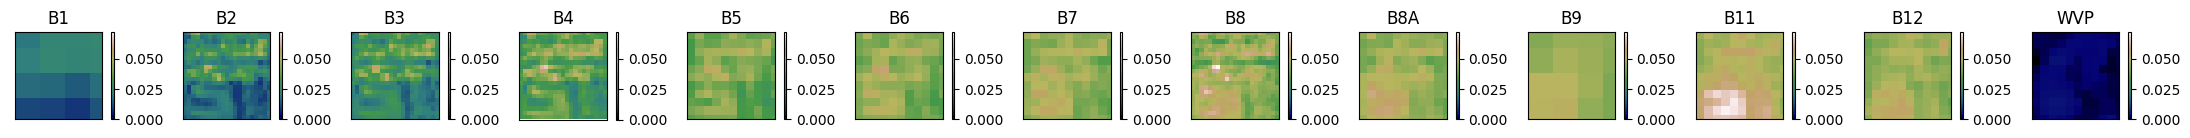

leak


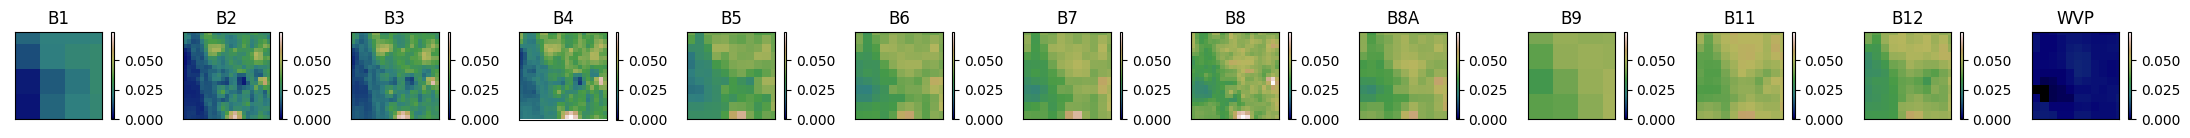

nonleak


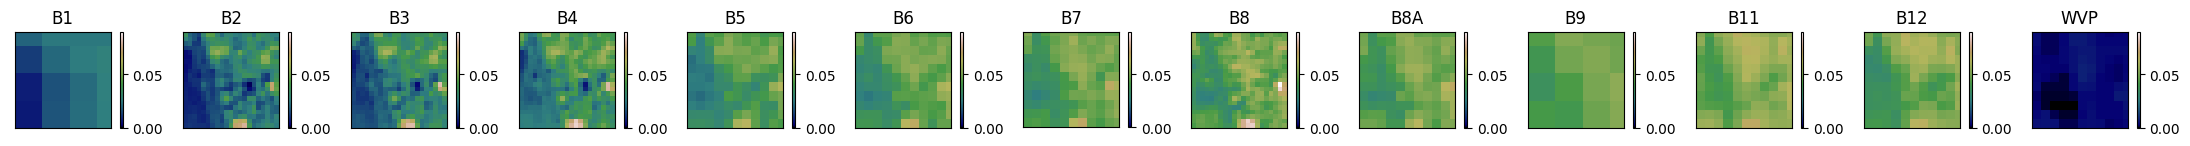

leak


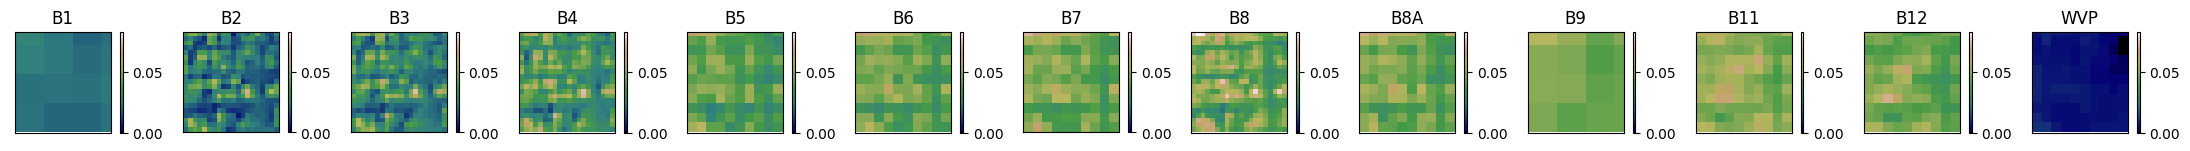

nonleak


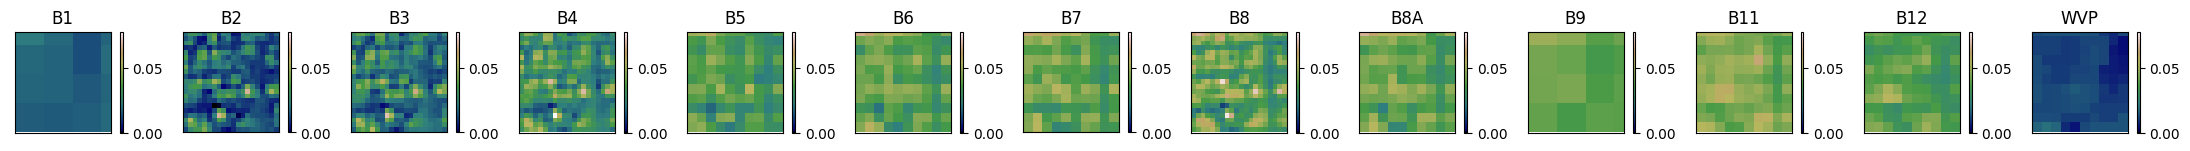

leak


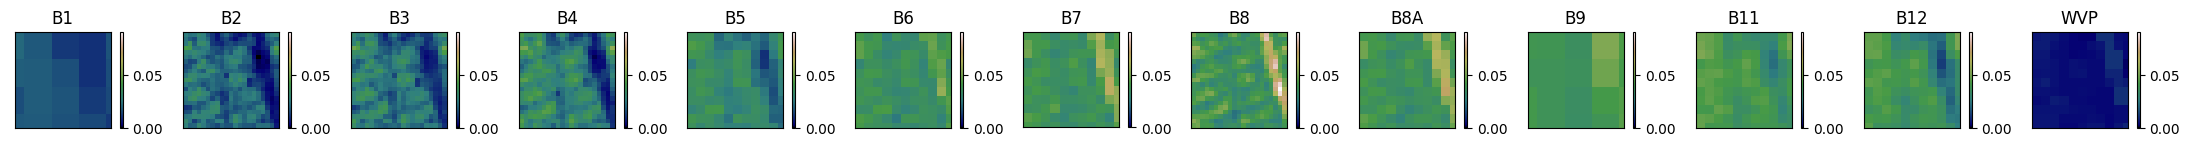

nonleak


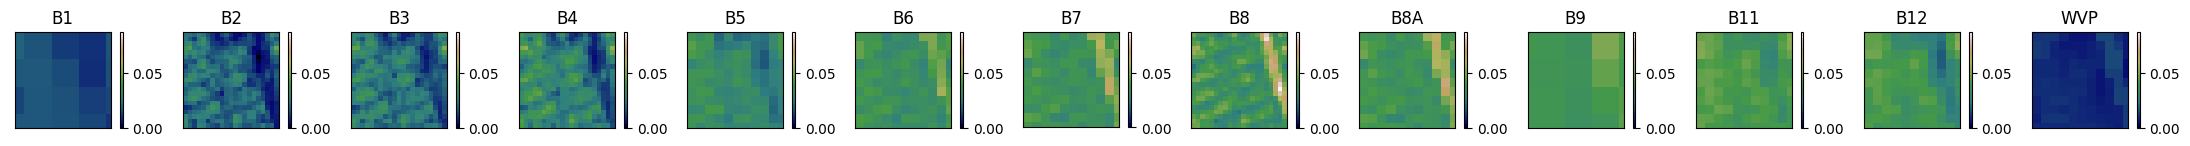

leak


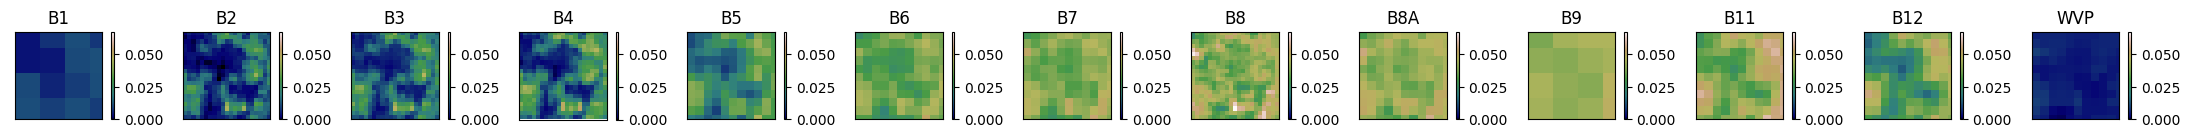

nonleak


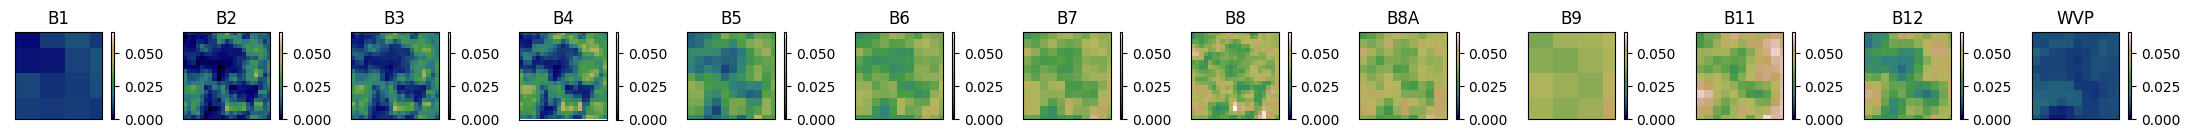

leak


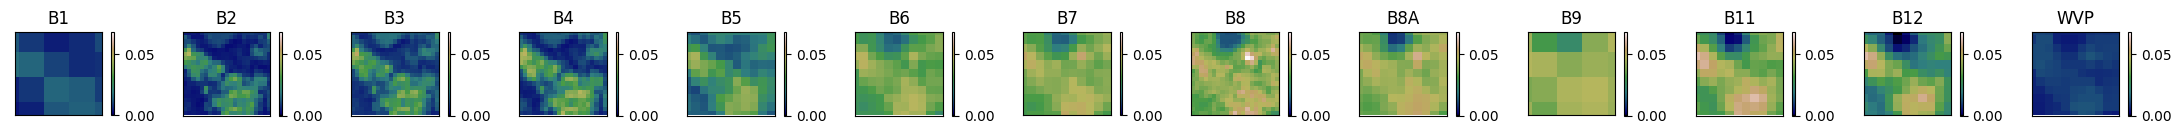

nonleak


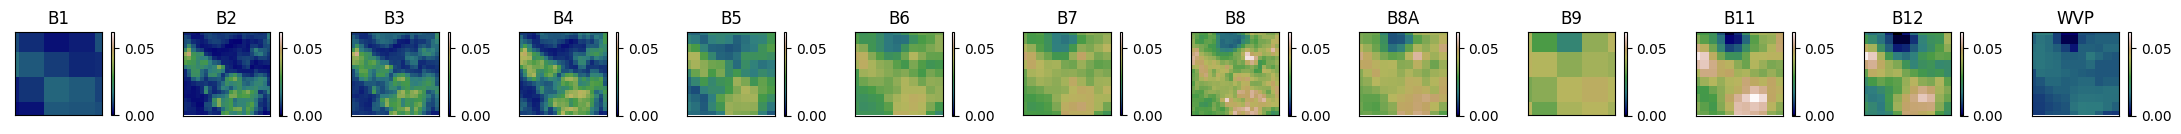

leak


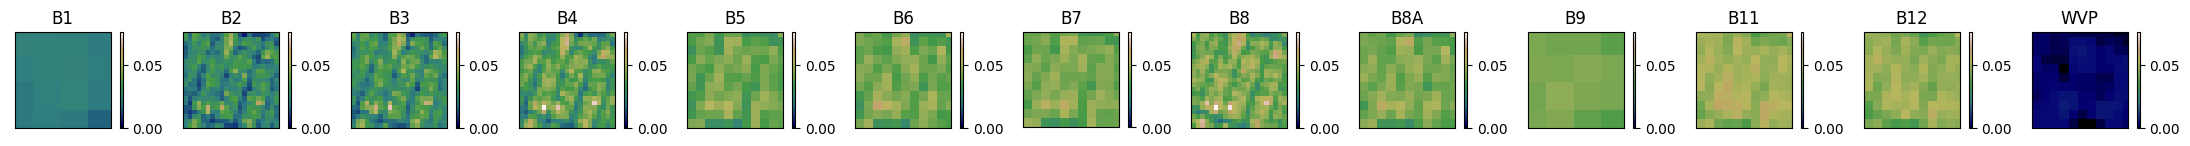

nonleak


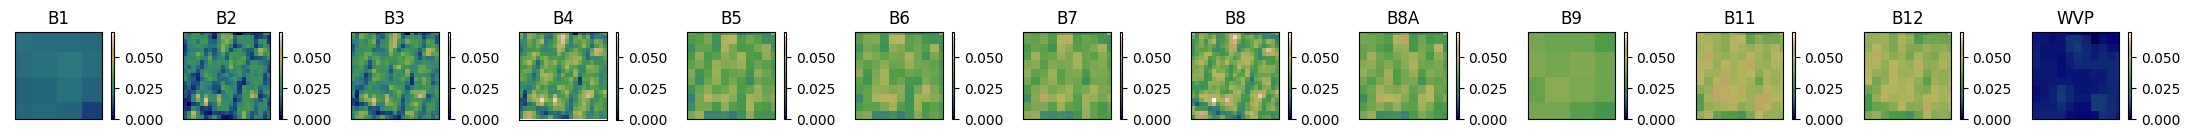

leak


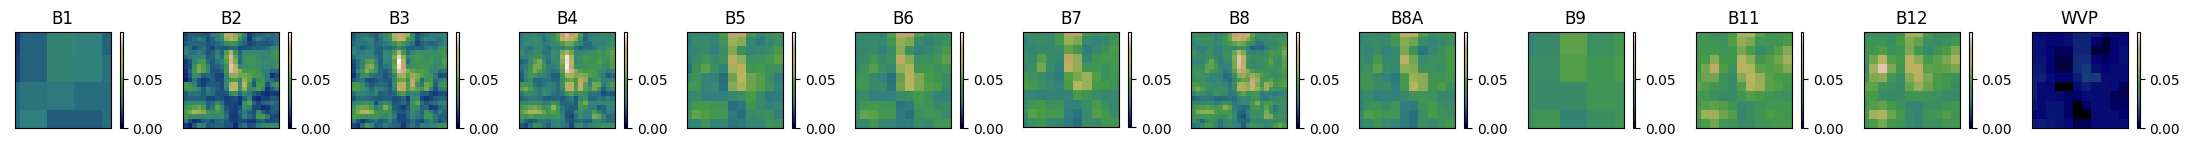

nonleak


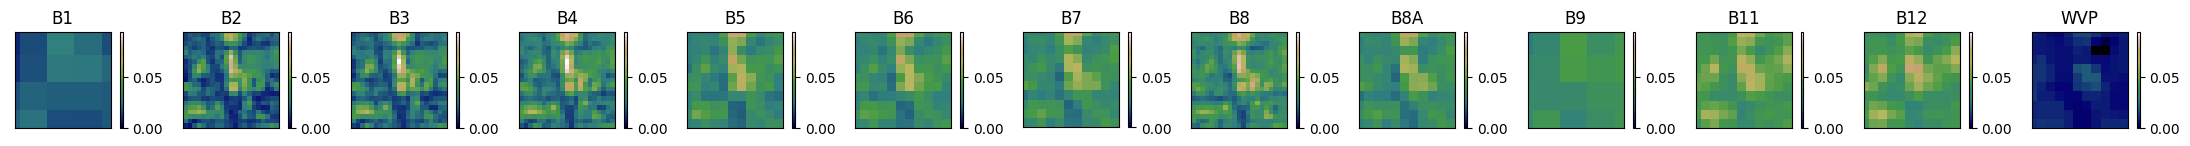

leak


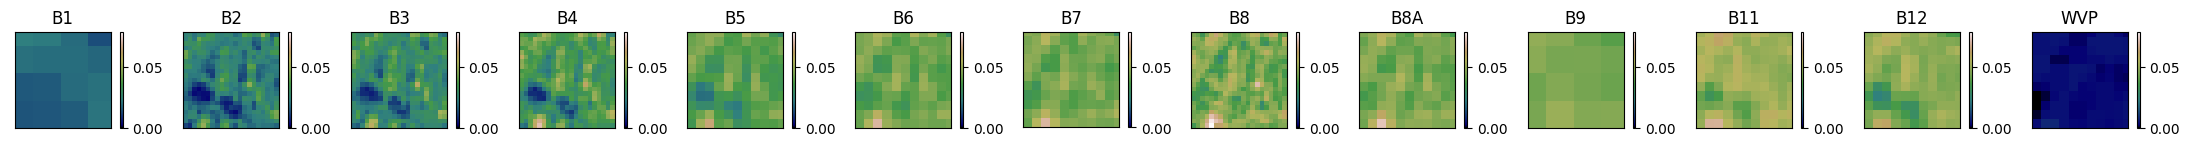

nonleak


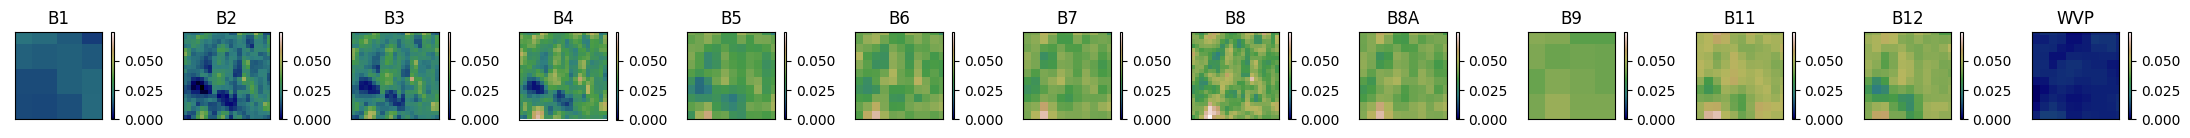

leak


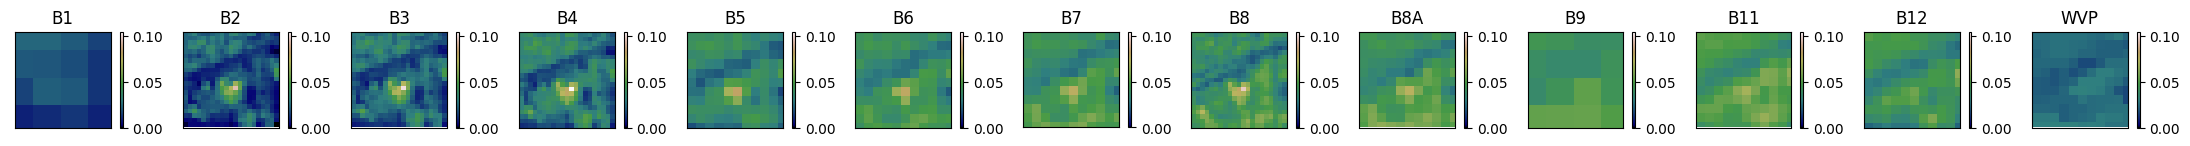

nonleak


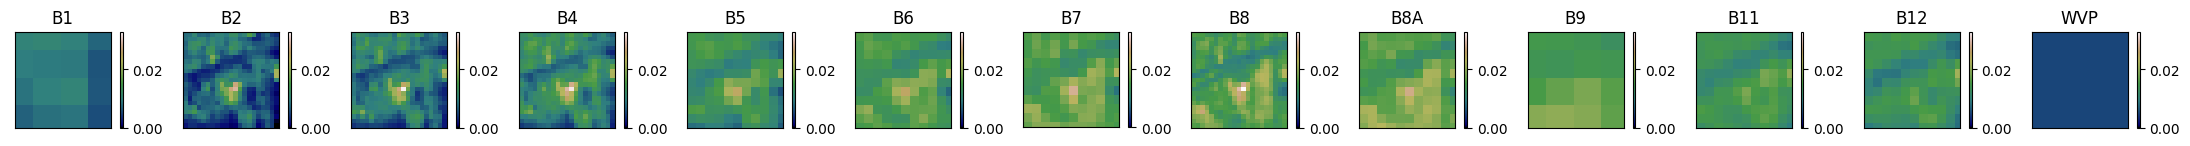

leak


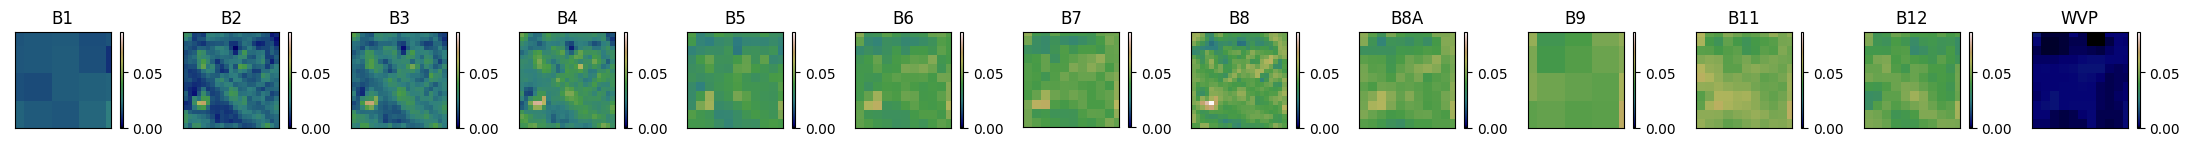

nonleak


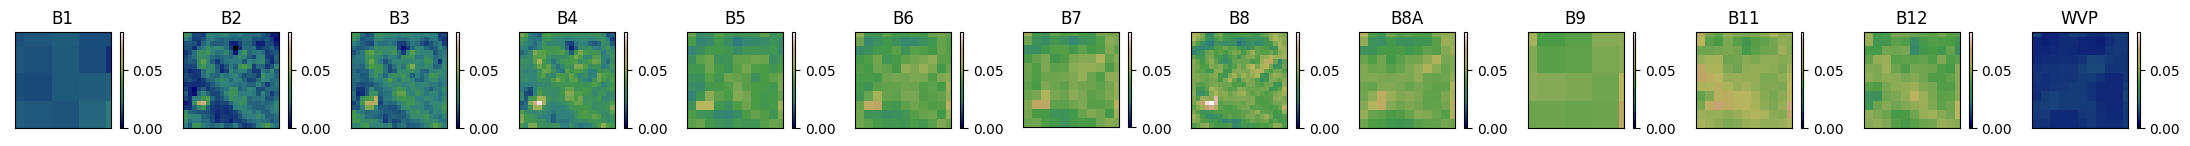

leak


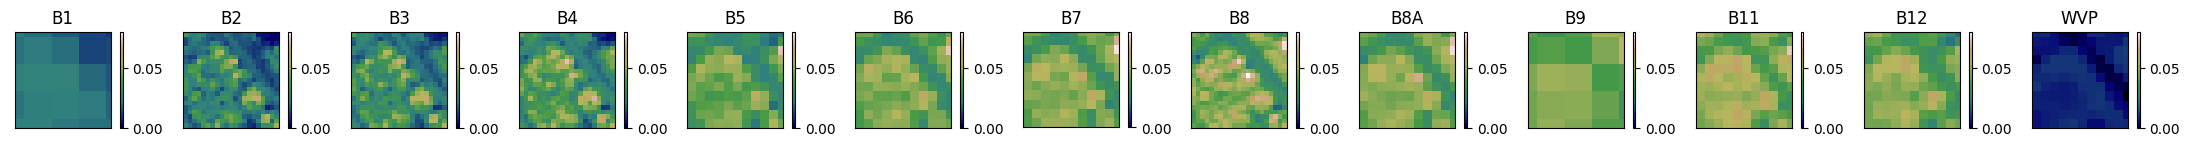

nonleak


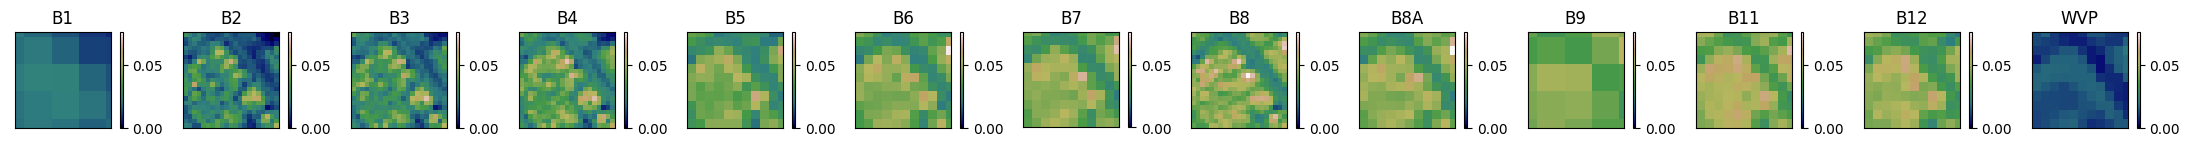

leak


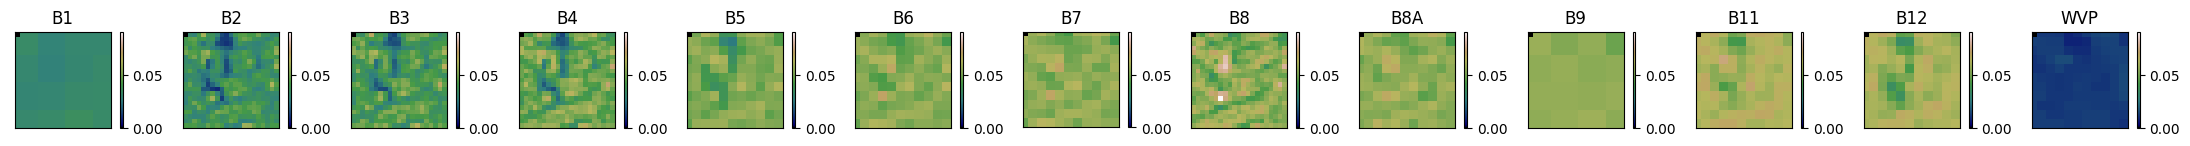

nonleak


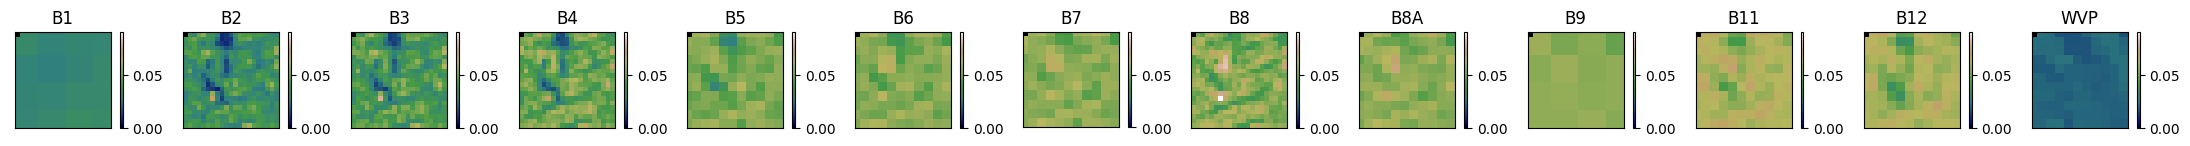

leak


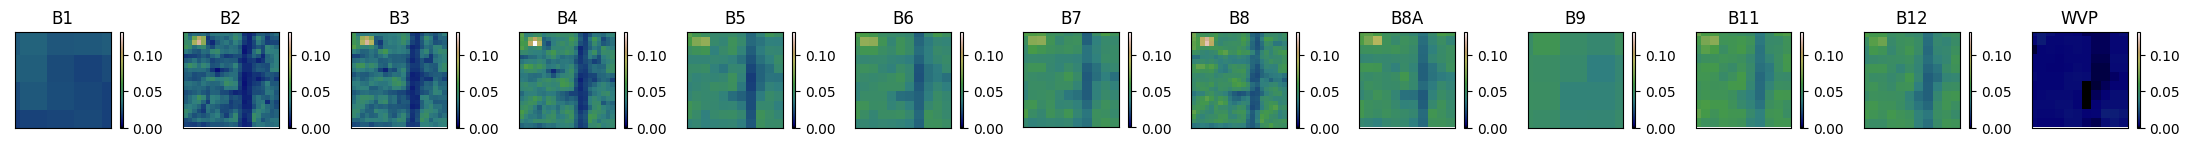

nonleak


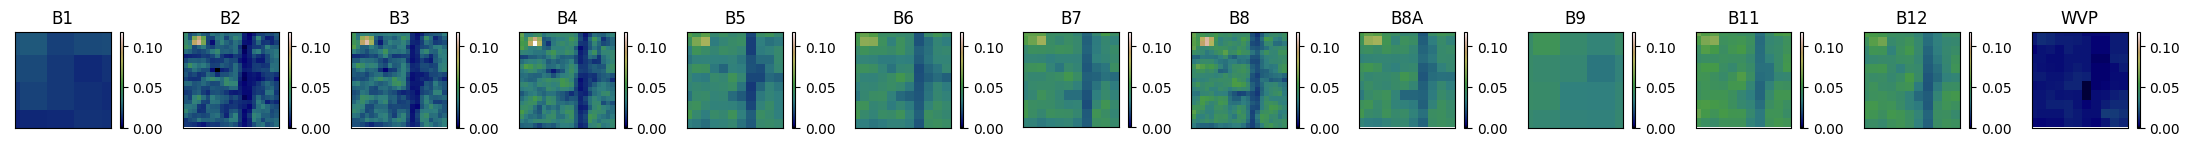

leak


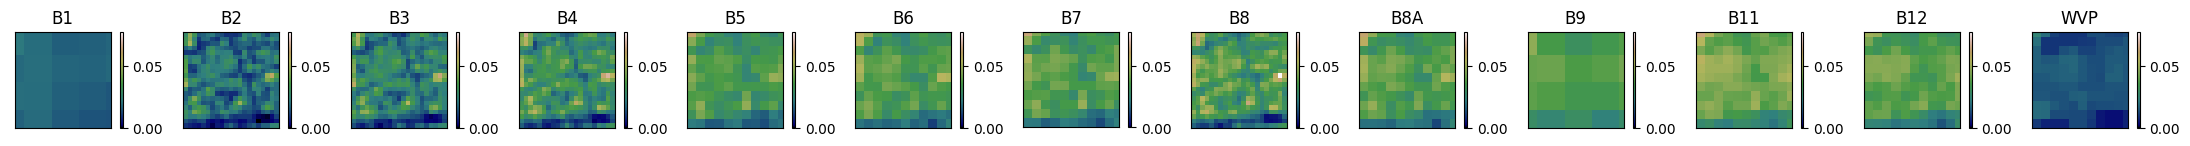

nonleak


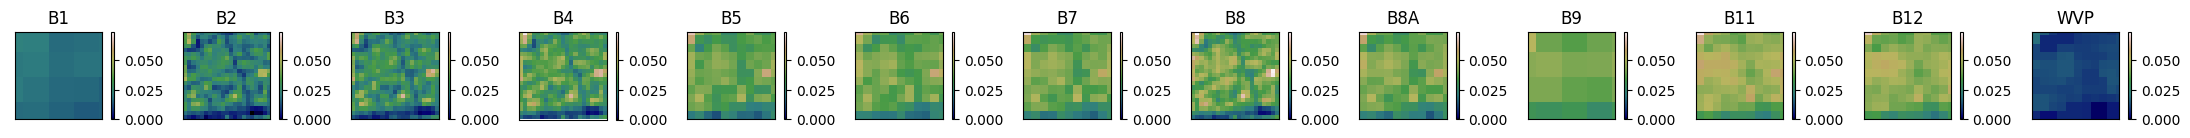

leak


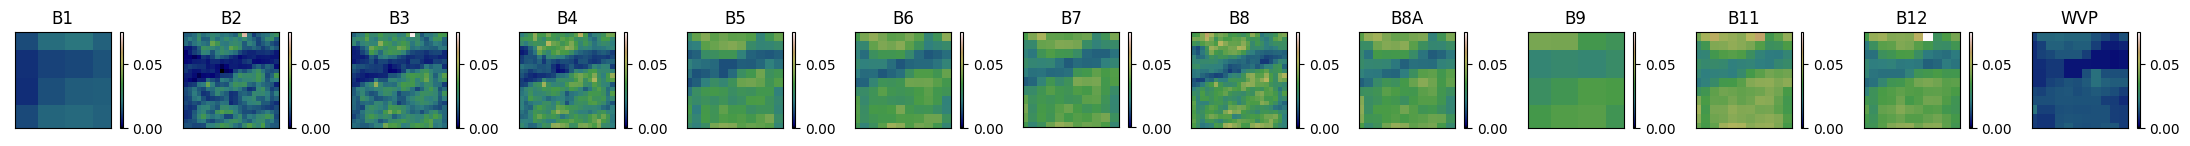

nonleak


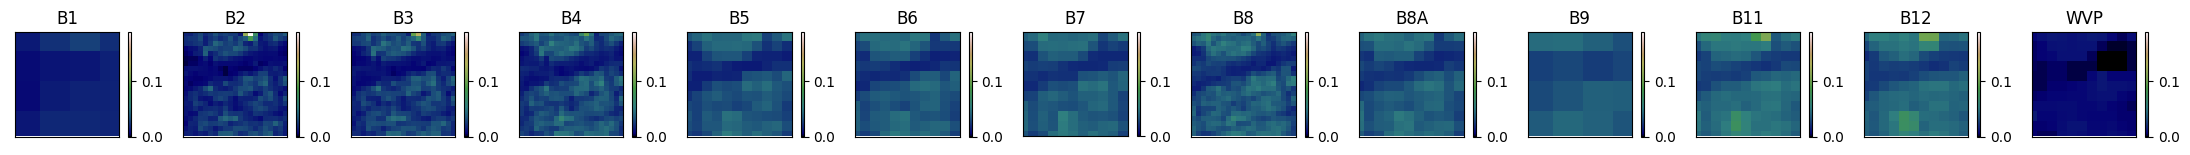

leak


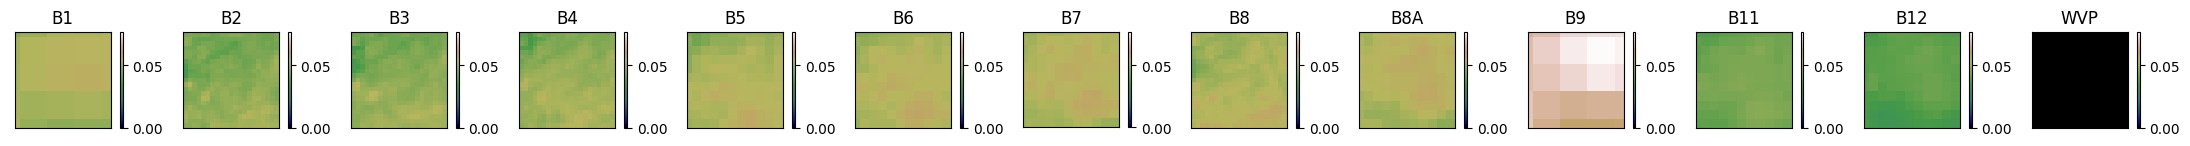

nonleak


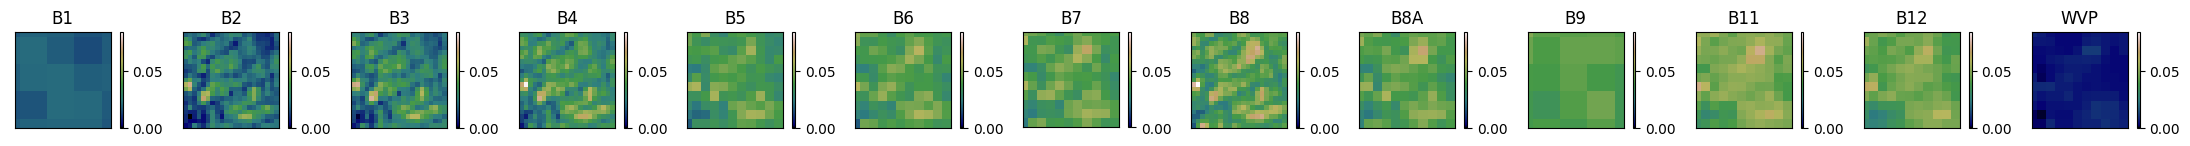

In [93]:
for i in range(0, len(leak_images_paths)):
    plot_bands(leak_images_paths[i], nonleak_images_paths[i])

### Land Surface Temperature plots

C:\Users\Erick\AppData\Local\Temp\ipykernel_32532\3725122185.py:4: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


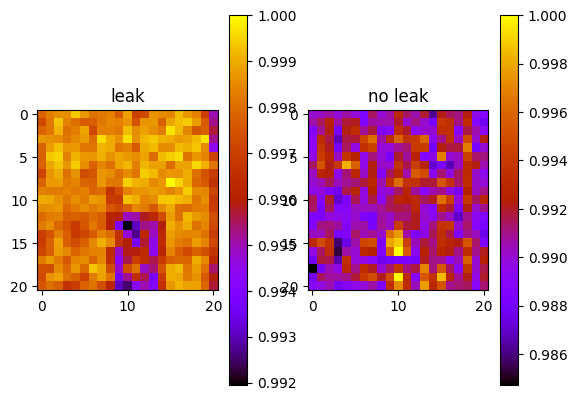

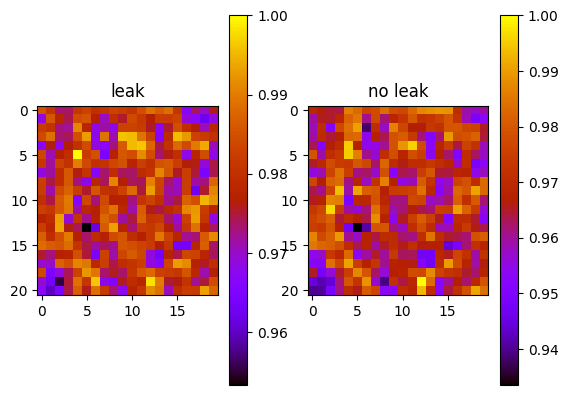

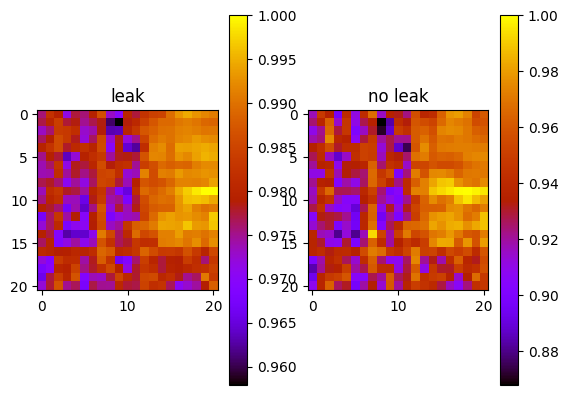

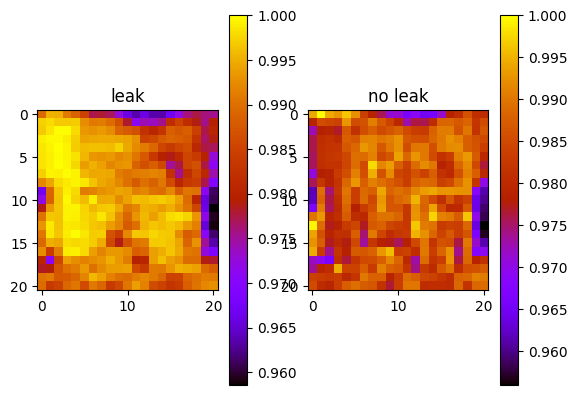

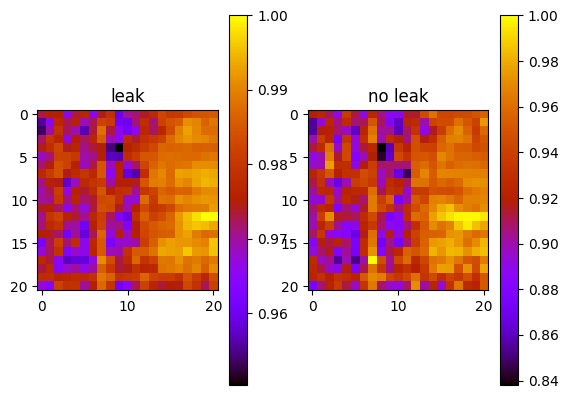

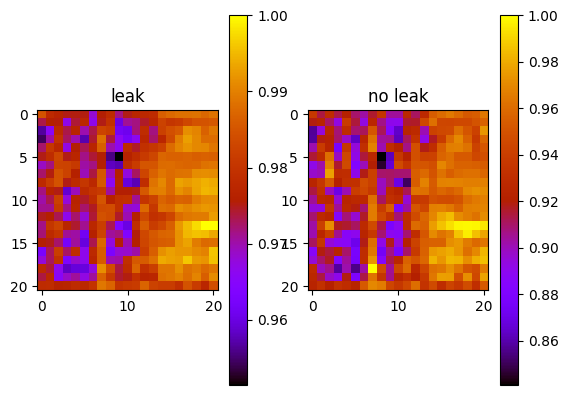

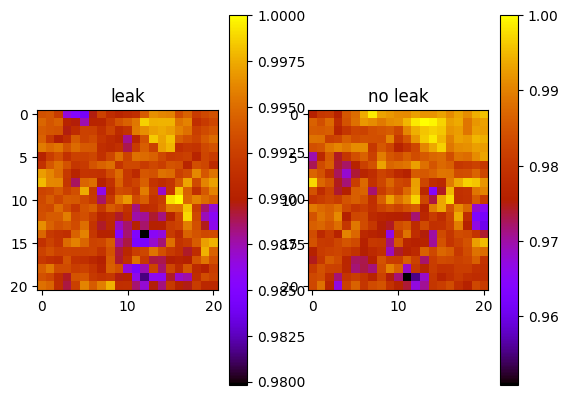

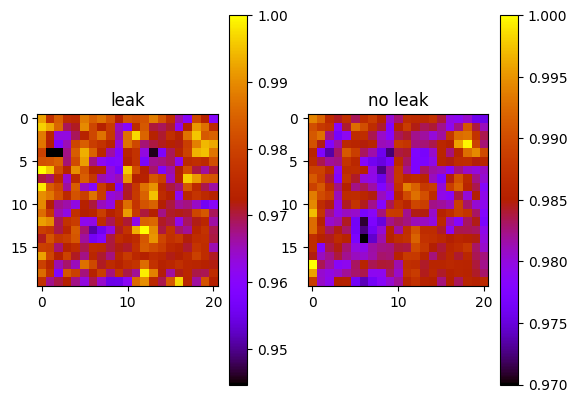

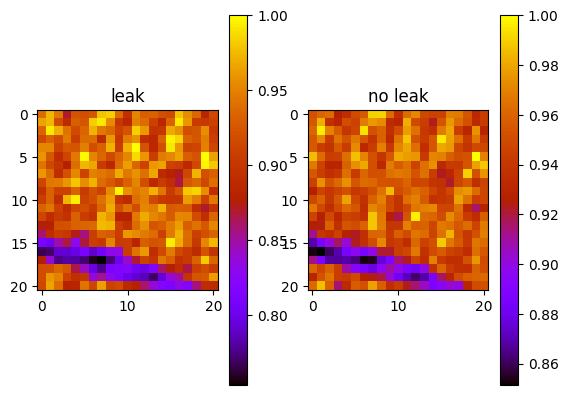

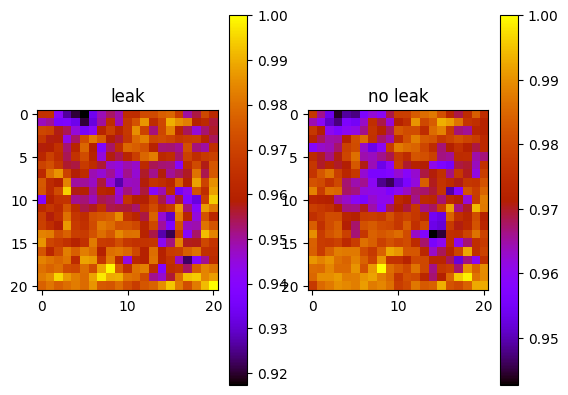

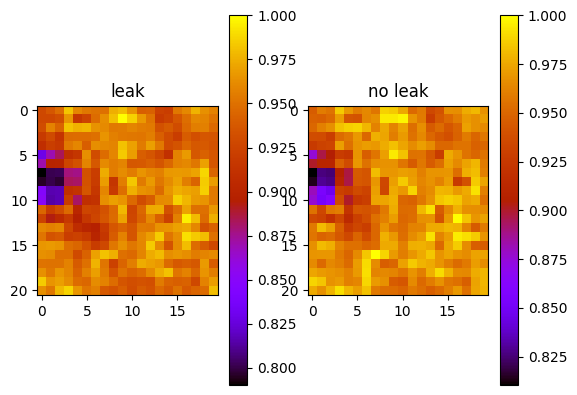

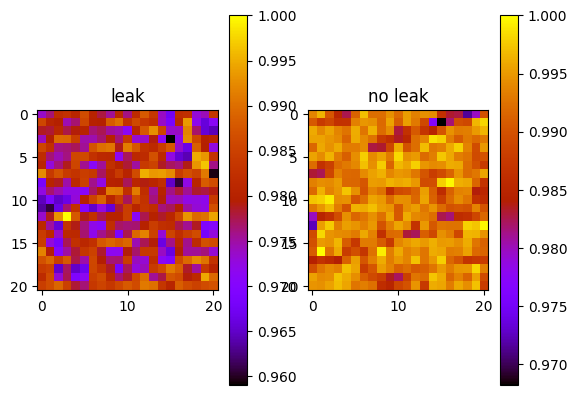

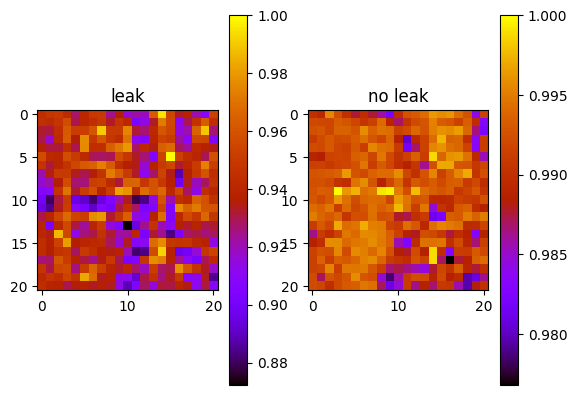

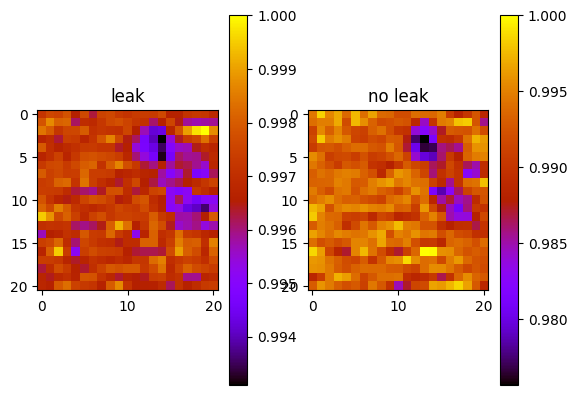

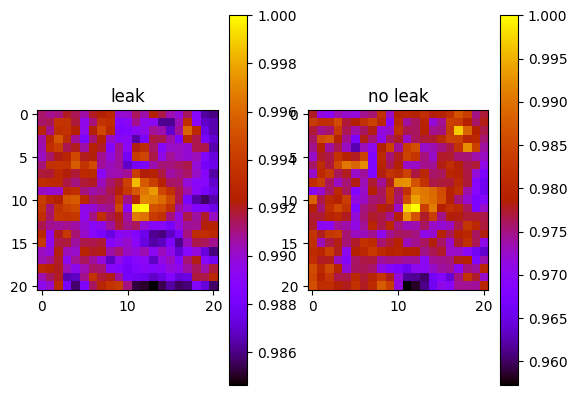

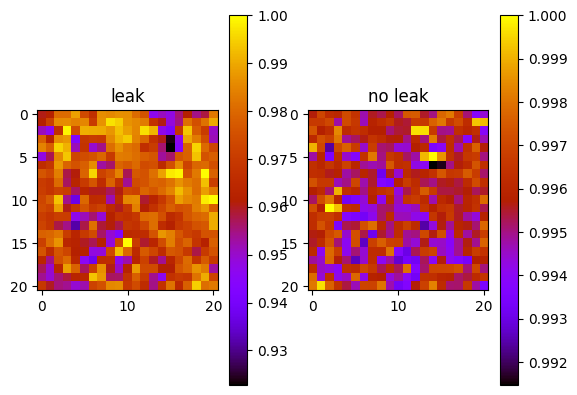

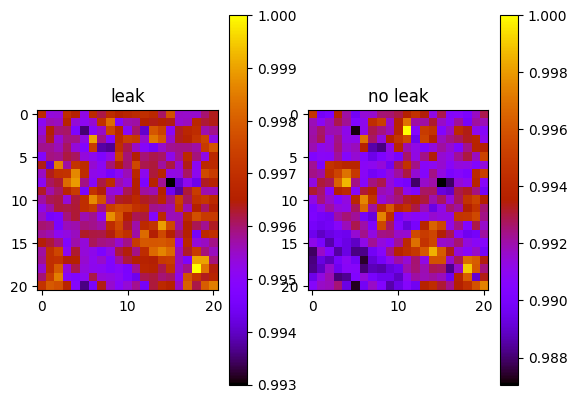

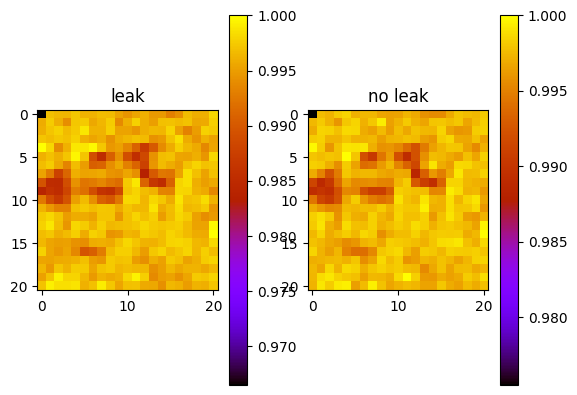

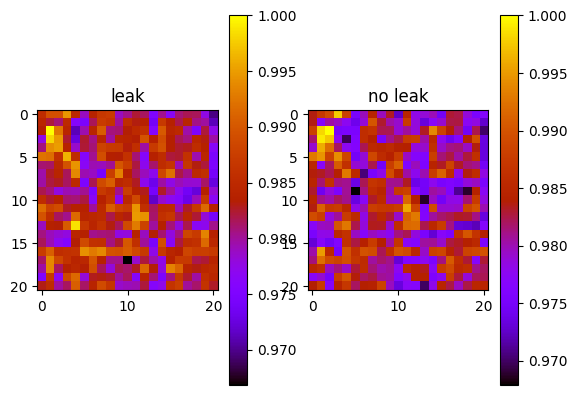

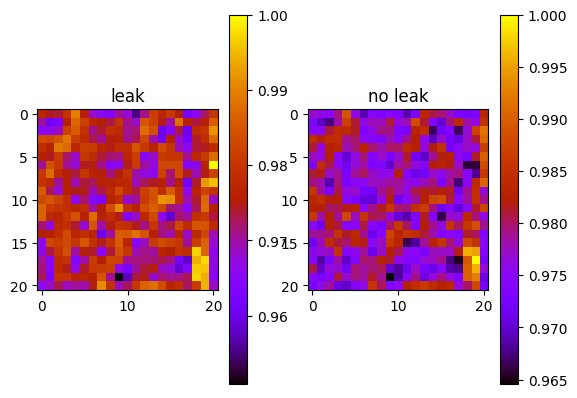

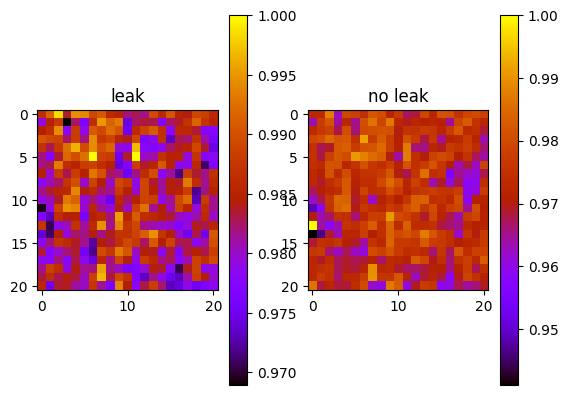

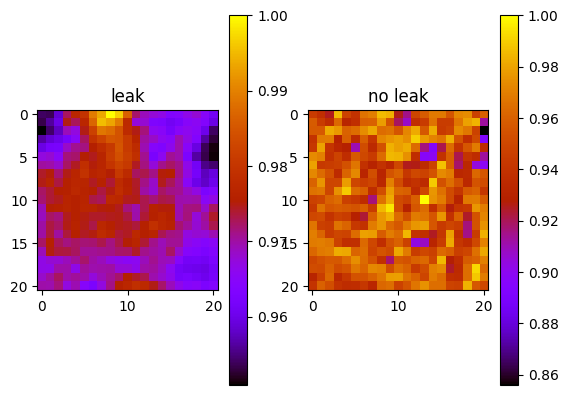

In [94]:
for i in range(0, len(leak_images_paths)):
    plot_lst(leak_images_paths[i], nonleak_images_paths[i])

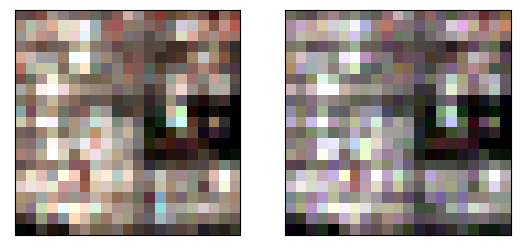

In [44]:
# RGB plot
fig, ((ax1, ax2)) = plt.subplots(nrows = 1, ncols = 2) 
ep.plot_rgb(ax = ax1,
    arr = np.transpose(stacked_image_leak), rgb = (3, 2, 1),
    stretch = True,
    figsize = (20, 10) 
    )

ep.plot_rgb(ax = ax2,
    arr = np.transpose(stacked_image_nonleak), rgb = (3, 2, 1),
    stretch = True,
    figsize = (20, 10) 
    )

plt.show()

### Histograms pixel per band

<Figure size 1200x100 with 0 Axes>

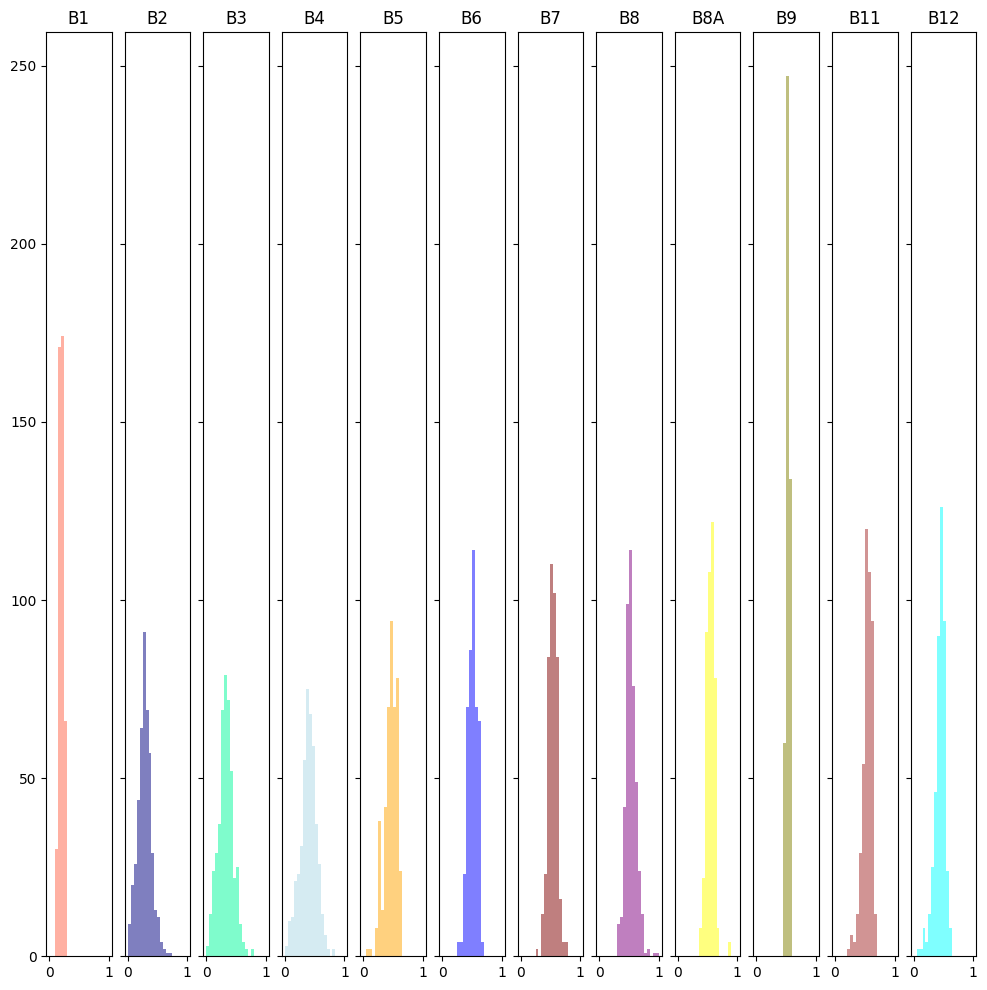

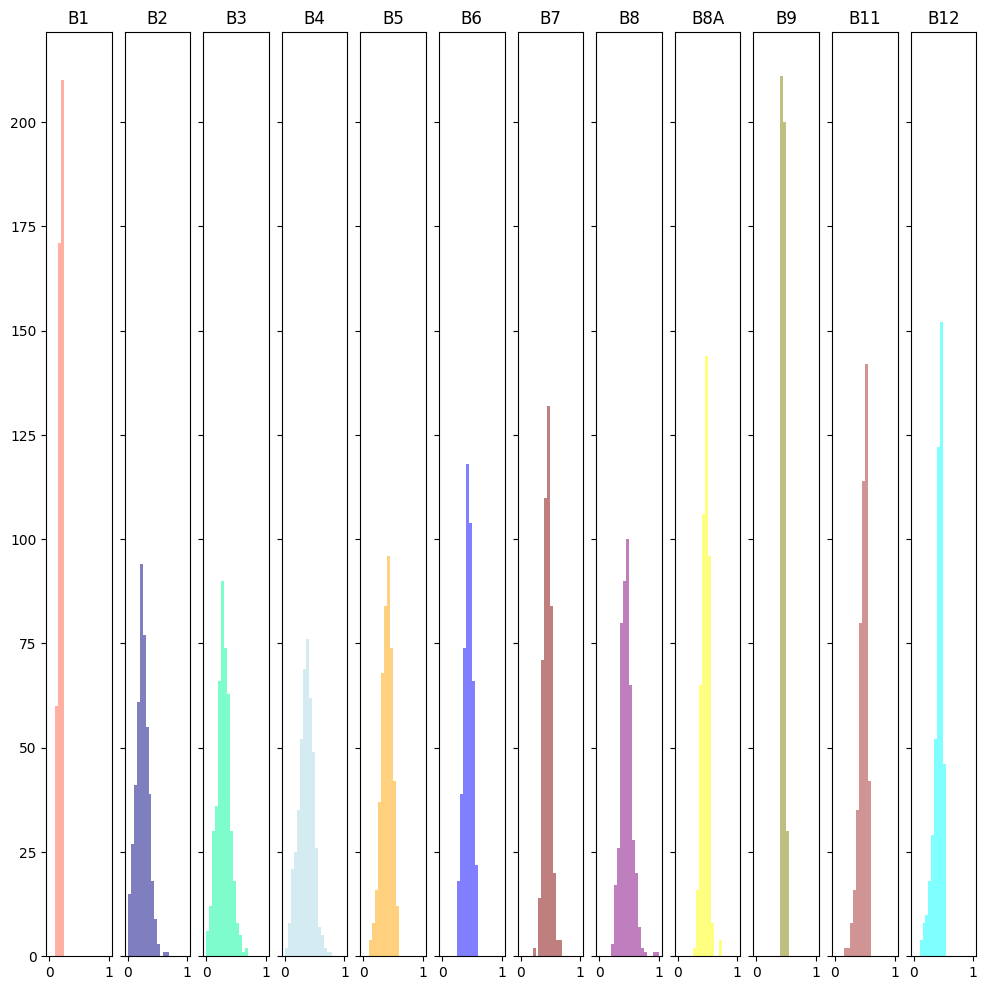

In [95]:
# histogram of pixels per band
colors = ['tomato', 'navy', 'MediumSpringGreen', 'lightblue', 'orange',
        'blue', 'maroon', 'purple', 'yellow', 'olive', 'brown', 'cyan', "black", "red"]

fig = plt.figure(figsize = (12,1))

ep.hist(
    arr = norm_bands(np.transpose(stacked_image_leak[:, :, :12])), colors = colors,
    title = titles[:12], cols = 12,
    alpha = 0.5
)

ep.hist(
    arr = norm_bands(np.transpose(stacked_image_nonleak[:, :, :12])), colors = colors,
    title = titles[:12], cols = 12,
    alpha = 0.5
)


plt.show()

### Normalized Difference Moisture Index plots

$NDMI = (NIR - SWIR)/(NIR + SWIR) = (B08 - B11)/(B08 + B11)$

In [96]:
def plot_ndmi(leak_tif_path, nonleak_tif_path):
    leak_tif = imread(leak_tif_path)
    nonleak_tif = imread(nonleak_tif_path)

    moisture_leak = es.normalized_diff(leak_tif[:, :, 7], leak_tif[:, :, 11])
    moisture_nonleak = es.normalized_diff(nonleak_tif[:, :, 7], nonleak_tif[:, :, 11])
    
    fig = plt.figure()
    fig.add_subplot(1, 2, 1)
    fig.colorbar(plt.imshow(moisture_leak, cmap = "RdYlGn"))
    plt.title("leak")
    
    fig.add_subplot(1, 2, 2)
    fig.colorbar(plt.imshow(moisture_nonleak, cmap = "RdYlGn"))
    
    plt.title("no leak")

c:\Users\Erick\AppData\Local\Programs\Python\Python311\Lib\site-packages\earthpy\spatial.py:105: RuntimeWarning: invalid value encountered in divide
  n_diff = (b1 - b2) / (b1 + b2)
C:\Users\Erick\AppData\Local\Temp\ipykernel_32532\2865103452.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


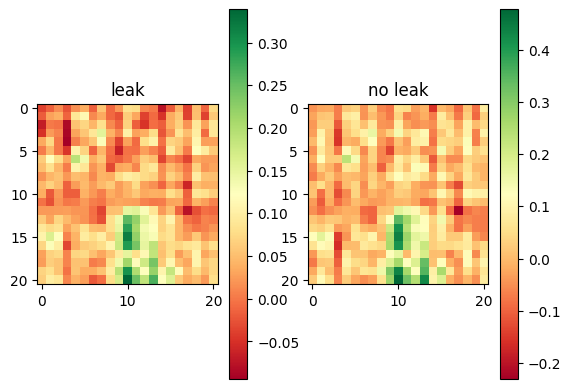

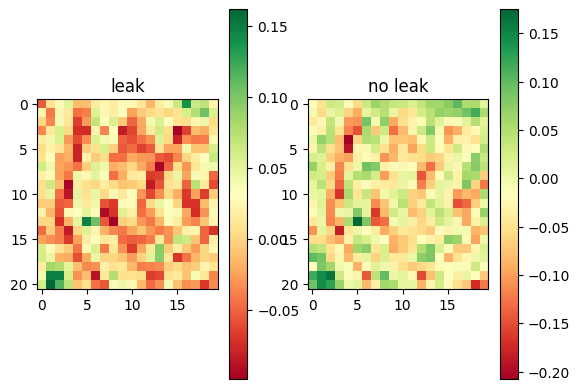

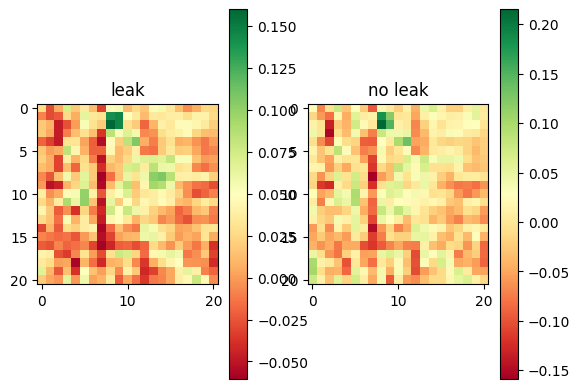

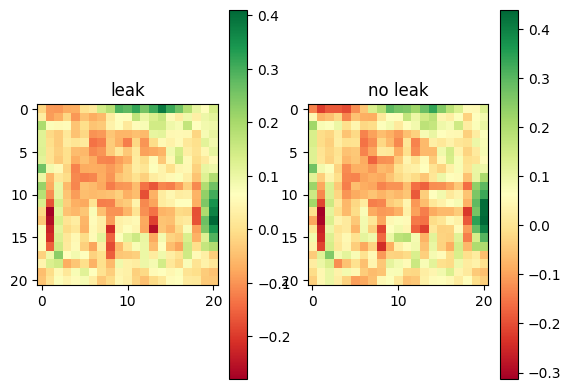

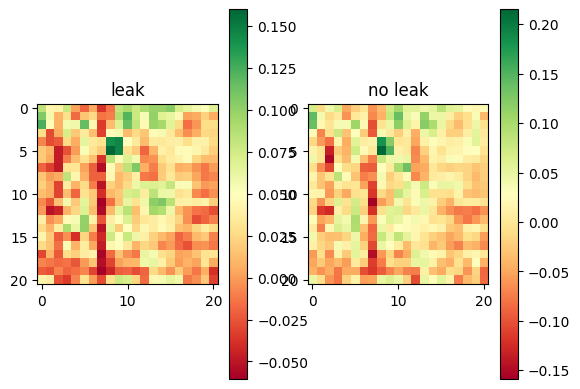

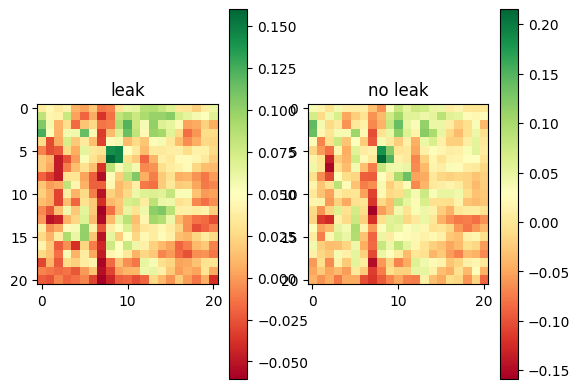

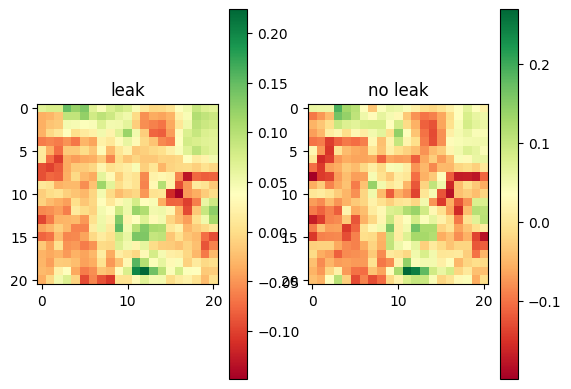

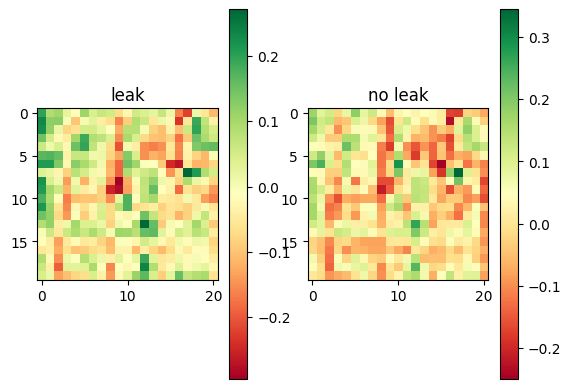

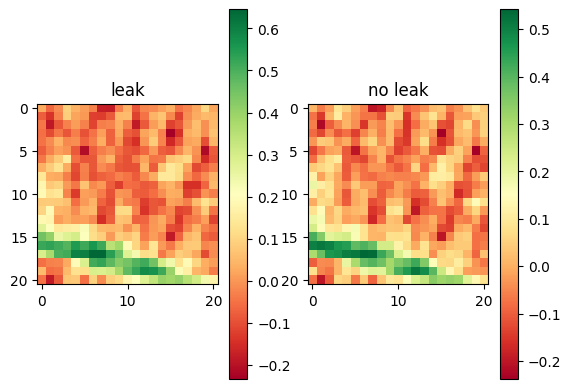

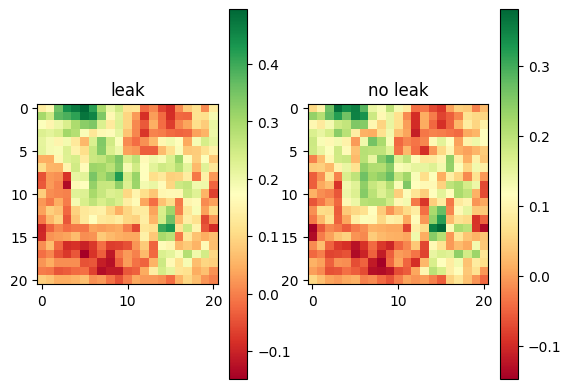

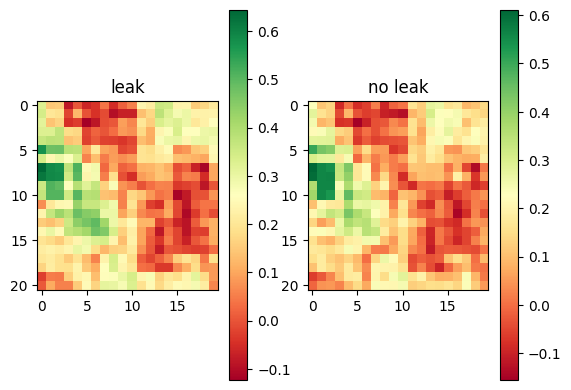

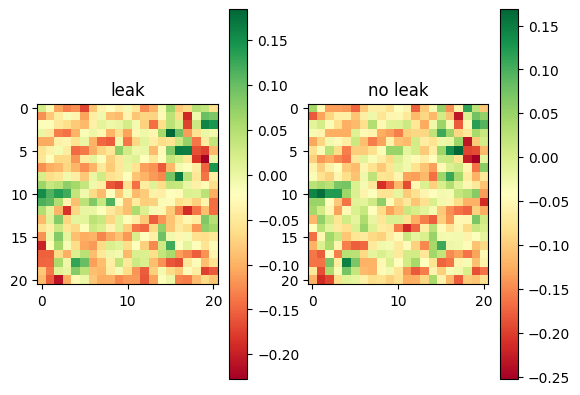

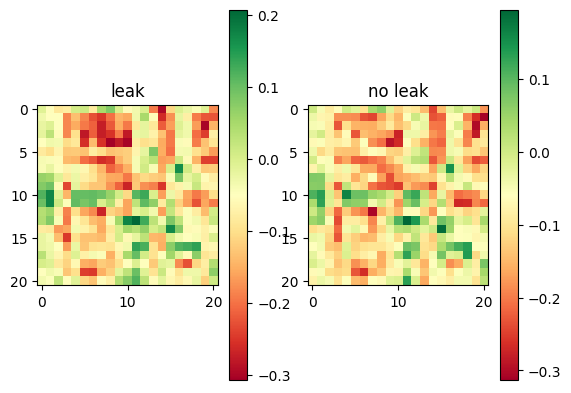

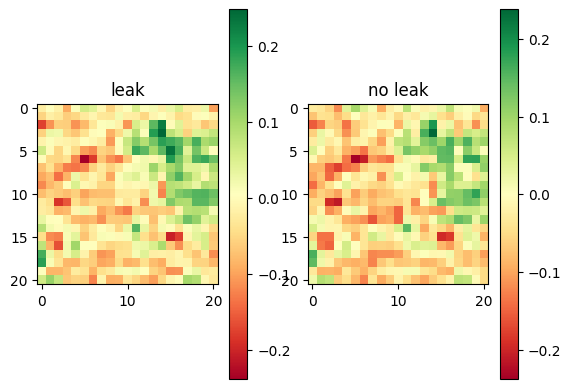

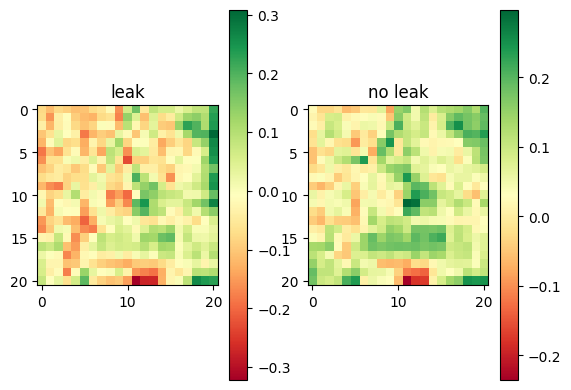

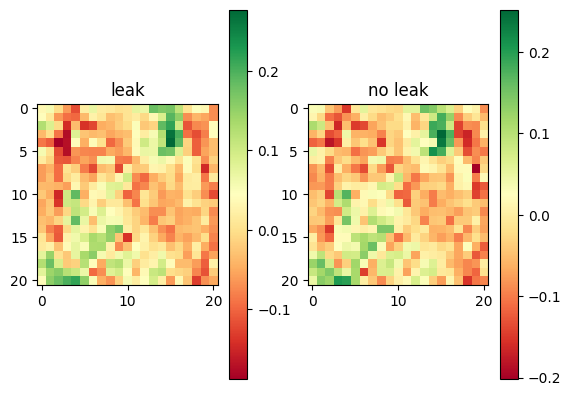

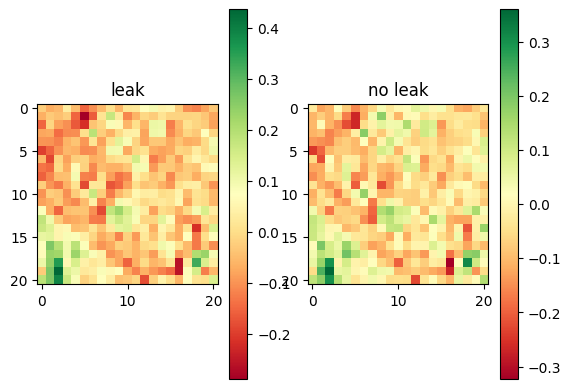

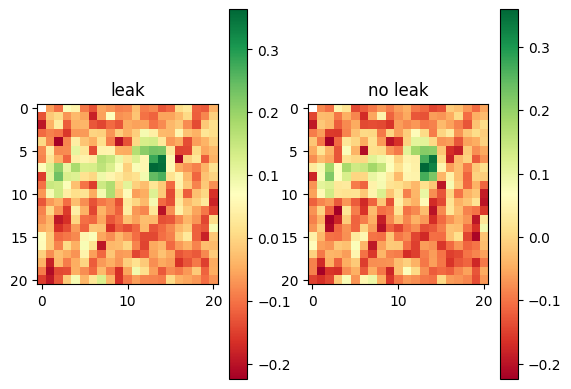

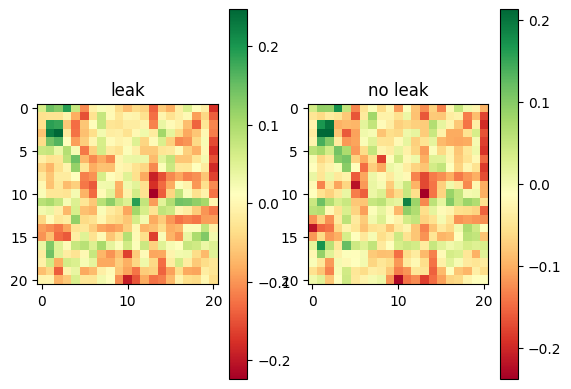

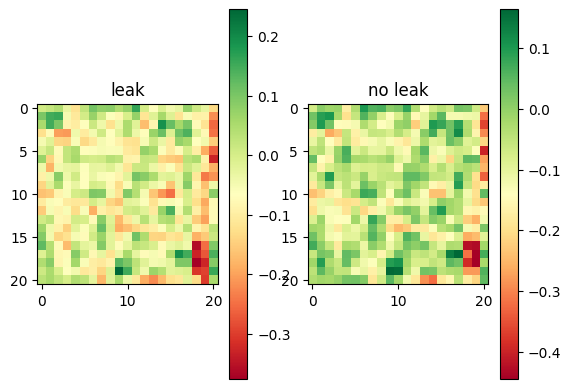

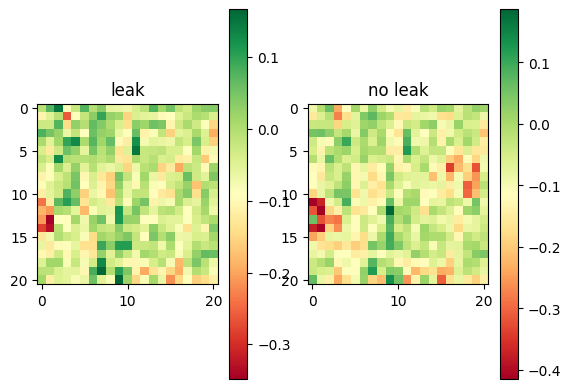

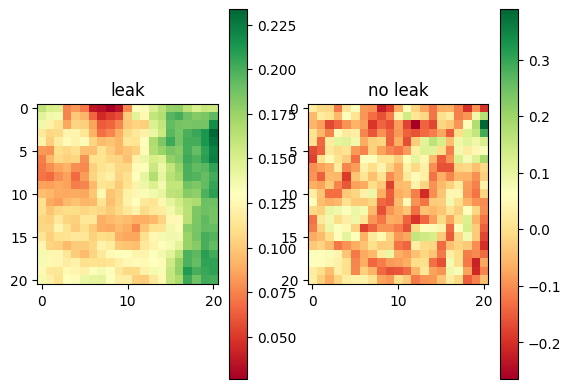

In [97]:
for i in range(0, len(leak_images_paths)):
    plot_ndmi(leak_tif_path = leak_images_paths[i], nonleak_tif_path = nonleak_images_paths[i])